# Model Evaluation & Predictions

##  Overview
This notebook loads the trained **Logistic Regression**, **Decesion Tree**, and **Random Forest** models to:
- Model performance metrics (Accuracy, Classification Report, Confusion Matrix)
- Cross-validation scores
- ROC Curves and AUC for model comparison

By the end of this notebook, we will determine which model is best suited for **predicting customer churn** and gain insights into **where the models make mistakes**.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score
import shap

# Load the dataset (assuming models are already trained in the previous notebook)
df = pd.read_csv("Model_Data.csv")

Evaluation Metrics for Logistic Regression
Accuracy: 0.8069552874378992
Classification Report:               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

Confusion Matrix: [[926 109]
 [163 211]]
--------------------------------------------------
Evaluation Metrics for Decision Tree
Accuracy: 0.794180269694819
Classification Report:               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.54      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.79      0.79      1409

Confusion Matrix: [[917 118]
 [172 202]]
------------------------------

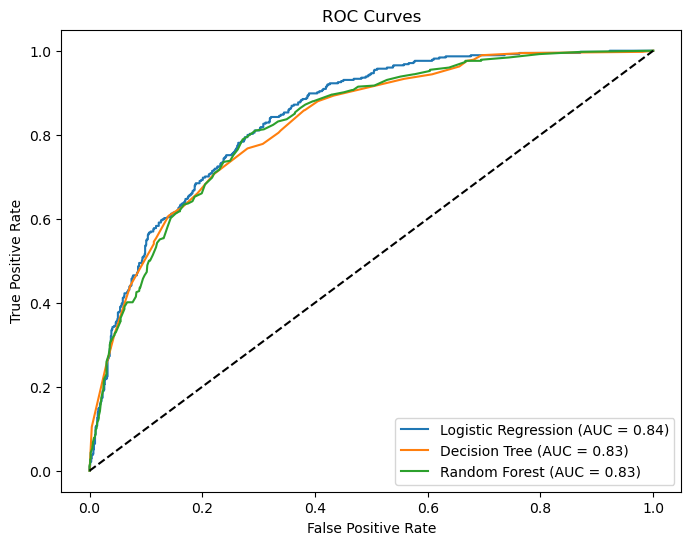

In [2]:
# Define Features (X) and Target (y)
X = df.drop(columns=["Churn"])
y = df["Churn"]

# Split into Training and Testing Sets (80% Train, 20% Test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Load trained models (Logistic Regression, Decision Tree, Random Forest)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

log_model = LogisticRegression()
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

log_model.fit(X_train_scaled, y_train)
tree_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_log = log_model.predict(X_test_scaled)
y_pred_tree = tree_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Model Evaluation Metrics
def evaluate_model(y_true, y_pred, model_name):
    print(f"Evaluation Metrics for {model_name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:", classification_report(y_true, y_pred))
    print("Confusion Matrix:", confusion_matrix(y_true, y_pred))
    print("-" * 50)

evaluate_model(y_test, y_pred_log, "Logistic Regression")
evaluate_model(y_test, y_pred_tree, "Decision Tree")
evaluate_model(y_test, y_pred_rf, "Random Forest")

# Cross-validation scores
cv_log = cross_val_score(log_model, X_train_scaled, y_train, cv=5)
cv_tree = cross_val_score(tree_model, X_train, y_train, cv=5)
cv_rf = cross_val_score(rf_model, X_train, y_train, cv=5)

print("Cross-validation Accuracy Scores:")
print("Logistic Regression:", np.mean(cv_log))
print("Decision Tree:", np.mean(cv_tree))
print("Random Forest:", np.mean(cv_rf))

# ROC Curves
plt.figure(figsize=(8, 6))

for model, y_pred_proba, name in zip(
    [log_model, tree_model, rf_model],
    [log_model.predict_proba(X_test_scaled)[:, 1], tree_model.predict_proba(X_test)[:, 1], rf_model.predict_proba(X_test)[:, 1]],
    ["Logistic Regression", "Decision Tree", "Random Forest"]
):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.savefig(os.path.join("Visuals", "ROC_Curve.png"))
plt.show()